In [1]:
import torch
import numpy as np
import math

In [117]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

from scipy.stats import pearsonr
import xarray as xr
import cmocean

import pyqg
import pyqg_explorer.util.misc as misc
import pyqg_explorer.util.transforms as transforms

In [87]:
import matplotlib.pyplot as plt

import xarray as xr

snap_index=5000

## Load in saved dataset
ds=xr.load_dataset("/scratch/cp3759/pyqg_data/sims/rollouts/rollout_BScat_252.nc")
ds_hr=xr.load_dataset("/scratch/cp3759/pyqg_data/sims/animation_sims/highres_1k.nc")

q=torch.tensor(ds.q[snap_index].to_numpy())
psi=torch.tensor(ds.p[snap_index].to_numpy())

dqdt=torch.tensor(ds.dqdt[snap_index].to_numpy())

q_hr=torch.tensor(ds_hr.q[500].to_numpy())
psi_hr=torch.tensor(ds_hr.p[500].to_numpy())

dqdt_hr=torch.tensor(ds_hr.dqdt[501].to_numpy())

In [98]:
class QG_kernel():
    def __init__(
        self,
        nx=64,                      # number of gridpoints
        dt=3600.,                   # numerical timestep
        L=1e6,                      # domain size is L [m]
        beta=1.5e-11,               # gradient of coriolis parameter
        rek=5.787e-7,               # linear drag in lower layer
        rd=15000.0,                 # deformation radius
        delta=0.25,                 # layer thickness ratio (H1/H2)
        H1 = 500,                   # depth of layer 1 (H1)
        U1=0.025,                   # upper layer flow
        U2=0.0,                     # lower layer flow
        **kwargs
        ):
        """
        Parameters
        ----------

        beta : number
            Gradient of coriolis parameter. Units: meters :sup:`-1`
            seconds :sup:`-1`
        rek : number
            Linear drag in lower layer. Units: seconds :sup:`-1`
        rd : number
            Deformation radius. Units: meters.
        delta : number
            Layer thickness ratio (H1/H2)
        U1 : number
            Upper layer flow. Units: meters seconds :sup:`-1`
        U2 : number
            Lower layer flow. Units: meters seconds :sup:`-1`
        """

        # physical
        self.beta = beta
        self.rek = rek
        self.rd = rd
        self.delta = delta
        self.Hi = np.array([ H1, H1/delta])
        self.U1 = U1
        self.U2 = U2
        self.nx = nx
        self.ny = nx
        self.L = L
        self.W = L
        self.nl = nx
        self.nk = nx/2 + 1
        self.dt = 3600
        
        # the F parameters
        self.F1 = self.rd**-2 / (1.+self.delta)
        self.F2 = self.delta*self.F1


        # initial conditions: (PV anomalies)
        self._initialise_q1q2()
        self._initialise_grid()
        
    def _initialise_grid(self):
        """ Set up real-space and spectral-space grids """
        
        self.x,self.y = torch.meshgrid(
        torch.arange(0.5,self.nx,1.)/self.nx*self.L,
        torch.arange(0.5,self.ny,1.)/self.ny*self.W )
        ## physical grid spacing
        self.dx = self.L / self.nx
        self.dy = self.W / self.ny

        # Notice: at xi=1 U=beta*rd^2 = c for xi>1 => U>c
        # wavenumber one (equals to dkx/dky)
        self.dk = 2.*math.pi/self.L
        self.dl = 2.*math.pi/self.W

        ## Define wavenumber arrays - nb that fft comes out
        ## with positive frequencies, then negative frequencies,
        ## and that rfft returns only half the plane
        self.ll = self.dl*torch.cat((torch.arange(0.,self.nx/2),
            torch.arange(-self.nx/2,0.)))
        self.kk = self.dk*torch.arange(0.,self.nk)

        ## Get wavenumber grids in complex plane
        self.k, self.l = torch.meshgrid(self.kk, self.ll)
        
        ## Torch meshgrid produces arrays with opposite indices to numpy, so we take the transpose
        self.k=self.k.T
        self.l=self.l.T
        self.ik = 1j*self.k
        self.il = 1j*self.l
        
        ## kappa2 represents the wavenumber squared at each gridpoint
        self.kappa2=(self.l**2+self.k**2)
        
        
        ## Evaluate 2x2 matrix determinant for calculation of streamfunction
        self.determinant=self.kappa2*(self.kappa2+self.F1+self.F2)
        ## Set to false value so matrix inversion doesn't throw warnings
        self.determinant[0,0]=1e-19
        
        return
        
    
    def _initialise_q1q2(self):
        self.q=torch.stack((1e-7*torch.rand(self.ny,self.nx) + 1e-6*(torch.ones((self.ny,1)) * torch.rand(1,self.nx) ),torch.zeros(self.nx,self.nx)))
        
        return
    
    def _invert(self,qh):
        """ Invert 2x2 matrix equation to get streamfunction from potential vorticity.
            Also return fft of streamfunction for use in other calculations """
        
        
        ph1=(-(self.kappa2+self.F2)*qh[0]-self.F1*qh[1])/self.determinant
        ph2=(-self.F2*qh[0]-(self.kappa2+self.F1)*qh[1])/self.determinant

        ## Fundamental mode is 0
        ph1[0,0]=0
        ph2[0,0]=0
        
        return torch.stack((ph1,ph2))
    
    def _invert_old(self,q):
        """ Invert 2x2 matrix equation to get streamfunction from potential vorticity.
            Also return fft of streamfunction for use in other calculations """
        q1_fft=torch.fft.rfftn(q1)
        q2_fft=torch.fft.rfftn(q2)
        
        ph1=(-(kappa2+self.F2)*q1_fft-self.F1*q2_fft)/dets
        ph2=(-m.F2*q1_fft-(kappa2+self.F1)*q2_fft)/dets

        ph1[0,0]=0
        ph2[0,0]=0

        psi_recons1=torch.fft.irfftn(ph1)
        psi_recons2=torch.fft.irfftn(ph2)
        
        return torch.stack((psi_recons1,psi_recons2))
    
    def diffx(self,x,prints=False):
        """ Central difference approximation to the spatial derivative in x direction 
            nb that our indices are [layer,y coordinate, x coordinate] so we torch.roll in
            dimension 2 for x derivative """
        if prints:
            x_plus_one=torch.roll(x,shifts=-1,dims=2)
            x_minus_one=torch.roll(x,shifts=1,dims=2)
            print("x_+1")
            print(x_plus_one)
            print("x_-1")
            print(x_minus_one)
            print("denom=",2*self.dx)
            print("prints done")

        return (torch.roll(x,shifts=-1,dims=2)-torch.roll(x,shifts=1,dims=2))/(2*self.dx)

    def diffy(self,x,prints=False):
        """ Central difference approximation to the spatial derivative in x direction 
            nb that our indices are [layer,y coordinate, x coordinate] so we torch.roll in
            dimension 1 for y derivative """
        
        if prints:
            x_plus_one=torch.roll(x,shifts=-1,dims=1)
            x_minus_one=torch.roll(x,shifts=1,dims=1)
            print("x_+1")
            print(x_plus_one)
            print("x_-1")
            print(x_minus_one)
            print("denom=",2*self.dx)
            print(x_plus_one-x_minus_one)
            print("prints done")

        return (torch.roll(x,shifts=-1,dims=1)-torch.roll(x,shifts=1,dims=1))/(2*self.dx)
    
    def _advect(self,q,psi):
        """ Arakawa advection scheme of q """
        
        f1 = self.diffx(psi)*self.diffy(q) - self.diffy(psi)*self.diffx(q)
        f2 = self.diffy(self.diffx(psi)*q) - self.diffx(self.diffy(psi)*q)
        f3 = self.diffx(self.diffy(q)*psi) - self.diffy(self.diffx(q)*psi)
        
        f = - (f1 + f2 + f3) / 3
        return f
        
    def rhs(self,q):
        """ Build a tensor of dq/dt """
        
        ## FFT of potential vorticity
        qh=torch.fft.rfftn(q,dim=(1,2))
        ## Spatial derivative of q field
        
        ## Invert coupling matrix to get streamfunction in Fourier domain
        ph=self._invert(qh)
        ## Invert fft to get streamfunction in real space
        psi=torch.fft.irfftn(ph,dim=(1,2))
        
        #### Spatial derivatives ####
        ## Spatial derivative of streamfunction using Fourier tensor
        dpsi=torch.fft.irfftn(1j*torch.sqrt(self.kappa2)*ph,dim=(1,2))
        d2psi=torch.fft.irfftn(self.kappa2*ph,dim=(1,2))
        dq=torch.fft.irfftn(1j*torch.sqrt(self.kappa2)*qh,dim=(1,2))
        
        ## Background quantities
        beta_upper=self.beta-self.F1*(self.U1-self.U2)
        beta_lower=self.beta+self.F2*(self.U1-self.U2)
        
        rhs=self._advect(q,psi)
        rhs[0]+=(-beta_upper*dpsi[0])
        rhs[1]+=(-beta_lower*dpsi[1])
        
        rhs[0]+=-dq[0]*self.U1
        rhs[1]+=-dq[1]*self.U2
        
        ## Bottom drag
        rhs[1]+=-self.rek*d2psi[1]
        
        return rhs
        
    def timestep(self,q):
        """ Advance system forward in time one step """
        
        """ 1. Need a function for the RHS
            2. Pass RHS to some numerical solver
            
        """
                
        return q+self.rhs(q)*self.dt
        

        

In [99]:
qg_kernel=QG_kernel(nx=64)

In [100]:
q_next=q
for aa in range(100):
    q_next=qg_kernel.timestep(q_next)

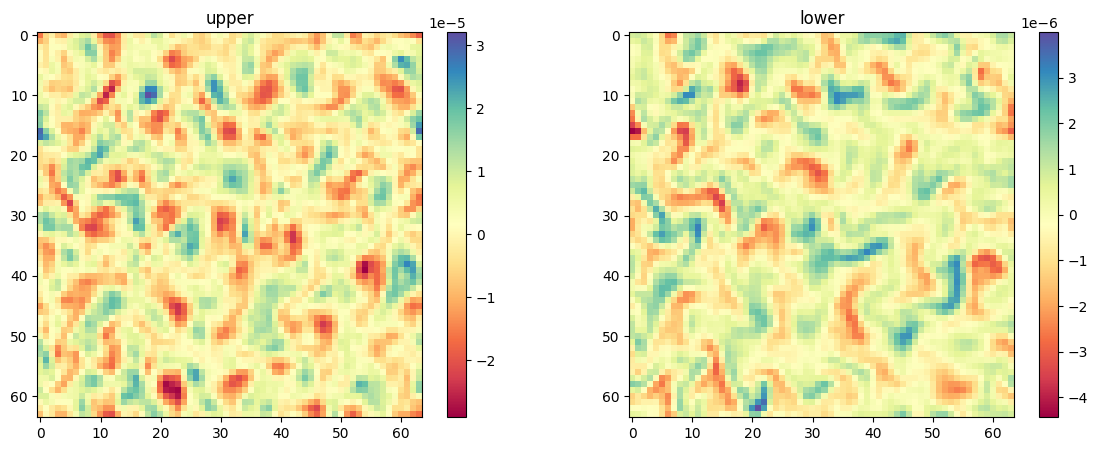

In [102]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(14,5))
im1=ax1.imshow(q_next[0],cmap="Spectral")
ax1.set_title("upper")
fig.colorbar(im1,ax=ax1,orientation='vertical')
im2=ax2.imshow(q_next[1],cmap="Spectral")
ax2.set_title("lower")
fig.colorbar(im2,ax=ax2,orientation='vertical')

In [122]:
class SimAnimation():
    def __init__(self,qinit,kernel,fps=10,nSteps=1000,normalise=True):
        self.q=qinit
        self.kernel=kernel
        self.fps = fps
        self.nSteps = nSteps
        
    def _push_forward(self):
        """ Update q by one timestep """
        
        self.q=self.kernel.timestep(self.q)
        
        return
    
    def animate_func(self,i):
        if i % self.fps == 0:
            print( '.', end ='' )
    
        ## Set image and colorbar for each panel
        image=self.q[0]
        self.ax1.set_array(image)
        #self.ax1.set_clim(-np.max(np.abs(image)), np.max(np.abs(image)))
        
        image=self.q[1]
        self.ax2.set_array(image)
        #self.ax2.set_clim(-np.max(np.abs(image)), np.max(np.abs(image)))
        self._push_forward()
        
        return 
    
    def animate(self):
        fig, (axs1,axs2) = plt.subplots(1, 2,figsize=(14,6))
        self.ax1=axs1.imshow(self.q[0], cmap=cmocean.cm.balance)
        fig.colorbar(self.ax1, ax=axs1)
        axs1.set_xticks([]); axs1.set_yticks([])
        axs1.set_title("Upper")

        self.ax2=axs2.imshow(self.q[1], cmap=cmocean.cm.balance)
        fig.colorbar(self.ax1, ax=axs2)
        axs2.set_xticks([]); axs2.set_yticks([])
        axs2.set_title("Lower")
        
        anim = animation.FuncAnimation(
                                       fig, 
                                       self.animate_func, 
                                       frames = self.nSteps,
                                       interval = 1000 / self.fps, # in ms
                                       )
        plt.close()
        
        return HTML(anim.to_html5_video())

In [124]:
simanim=SimAnimation(q,qg_kernel,fps=60,nSteps=200)
simanim.animate()

.....

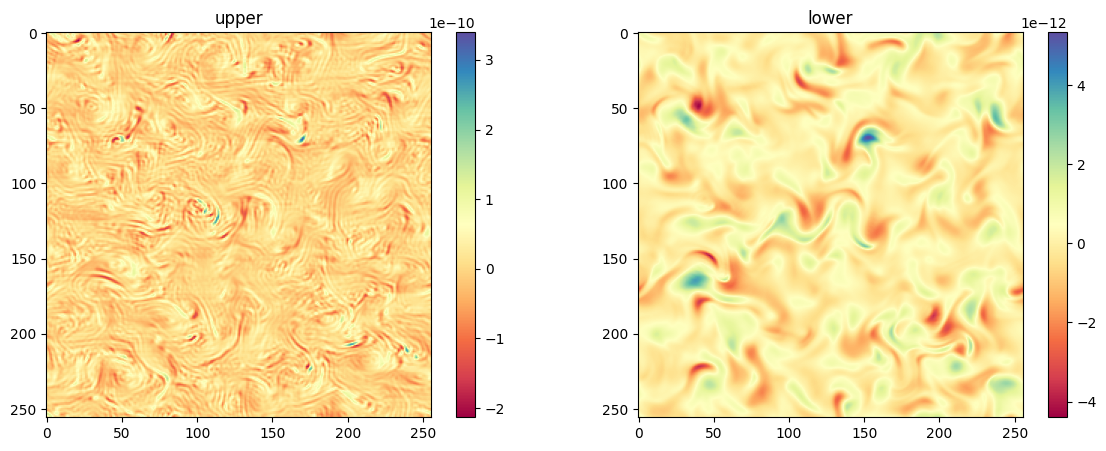

In [85]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(14,5))
im1=ax1.imshow(rhs[0],cmap="Spectral")
ax1.set_title("upper")
fig.colorbar(im1,ax=ax1,orientation='vertical')
im2=ax2.imshow(rhs[1],cmap="Spectral")
ax2.set_title("lower")
fig.colorbar(im2,ax=ax2,orientation='vertical')

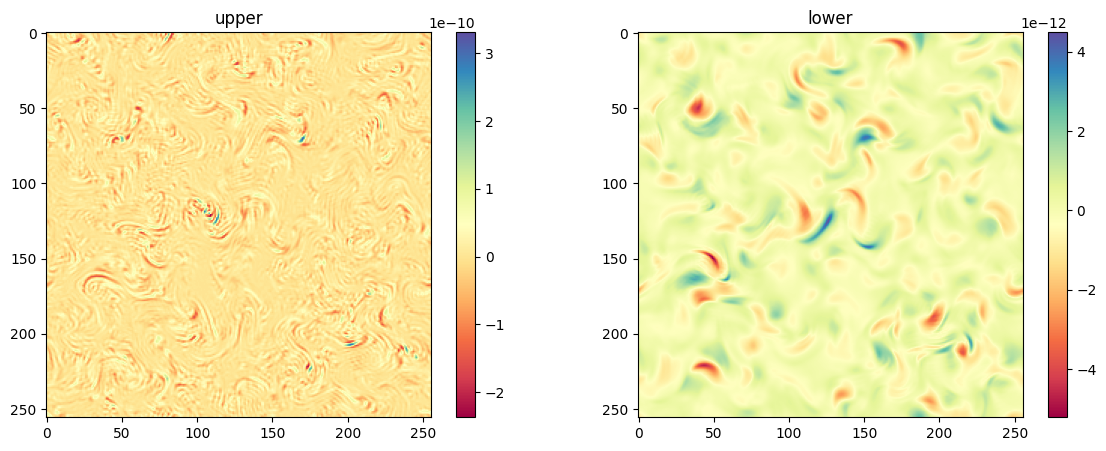

In [88]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(14,5))
im1=ax1.imshow(dqdt_hr[0],cmap="Spectral")
ax1.set_title("upper")
fig.colorbar(im1,ax=ax1,orientation='vertical')
im2=ax2.imshow(dqdt_hr[1],cmap="Spectral")
ax2.set_title("lower")
fig.colorbar(im2,ax=ax2,orientation='vertical')